In [1]:
#Fresh Cortex from Adult Mouse Brain (P50) - Epi ATAC v.10 - fresh
 

In [2]:
#install packages
# !pip install pandas
# !pip install scipy
# !pip install pyfaidx
# !pip install scikit-learn
# !pip install scanpy 
# !pip install anndata
# !pip install igraph
# !pip install leidenalg
import sys
import anndata
import tensorflow as tf
import matplotlib.pyplot as plt
print(sys.executable)


/opt/anaconda3/envs/VIB_model/bin/python


In [3]:
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import numpy as np 

#load matrix
matrix = mmread("filtered_peak_bc_matrix/matrix.mtx").tocsc()

#load peaks
peaks = pd.read_csv("filtered_peak_bc_matrix/peaks.bed", sep = "\t", header = None)
barcodes = pd.read_csv("filtered_peak_bc_matrix/barcodes.tsv", header = None)

#assign rows and cols
peaks.columns = ["chr", "start", "end"]
barcodes.columns = ["cell_barcode"]
print(peaks)

         chr     start       end
0       chr1   3094708   3095552
1       chr1   3119414   3121782
2       chr1   3204809   3205178
3       chr1   3217330   3217359
4       chr1   3228123   3228463
...      ...       ...       ...
157792  chrY  90761049  90762169
157793  chrY  90800417  90800831
157794  chrY  90804515  90805440
157795  chrY  90808545  90809111
157796  chrY  90810741  90810960

[157797 rows x 3 columns]


In [4]:
matrix_binary = (matrix>0).astype(int)
#sup per cell - how many cells have that peak accessible /peak cessible per cell - cols are cells but are not shown
peak_accessibility = matrix_binary.sum(axis=1)

print(peak_accessibility)
#convert to A1 numpy array
peaks_accessibility_1D = peak_accessibility.A1

[[260]
 [731]
 [ 86]
 ...
 [453]
 [407]
 [ 61]]


In [ ]:
v#Perform Pre-processing with Scanpy
matrix_Transposed = matrix_binary.T # trasnpose the matrix so it is cells x peaks - Scanpy expect that 
#assign barcodes columns

#create AnnData object (Scanpy's mani data structure)
#adata,X cords (row_idx = cell idx, cold_idx = peak_idx)  value 1 or 0
adata = anndata.AnnData(X = matrix_Transposed)
adata.obs_names = barcodes['cell_barcode'].values #cell meatadata live in adata.obs 

#store in how many cells each peak is acessibile -  into feature metadata(variables)
adata.var["peaks_accessibility"] = peaks_accessibility_1D #peak metadata live in adata.var

#rows , peaks.... each row return a sparse matrix for each cell
#(5K cells , 157K pekas)
print(adata.X.shape)


(5337, 157797)


In [6]:
#count the number of zeros in the sparse matrix
total_entries = adata.X.shape[0] * adata.X.shape[1]
nonzero_entries = adata.X.count_nonzero()
sparsity =  100 * (1 - nonzero_entries/total_entries)

print(f"sparsity: {sparsity: .2f}% of the matrix is 0")

sparsity:  94.42% of the matrix is 0


In [7]:
from sklearn.feature_extraction.text import TfidfTransformer

#Step 2: perform TermFrequency(TF) -InverseDocumentFrequency(IDF) normalization
#NLP comparison --> term = peak, document = cell, 
#Tf(j) = accessibility peak j in cell i/total accessible peaks in cell i,IDF(j)=log((1 + N(cells) / 1 + nj (number of cells with peak j accessible)) 
#TF-D= Tf x idf, sparse matrix preserved --> TF weighed measure of peak acessibility emphasizing rare but specific signals.
tf_idf = TfidfTransformer()
X_tfidf = tf_idf.fit_transform(adata.X)

#update anndata with normalized data 
#now the values are weighted accessibility scores, higher value = peak specifically accessible in given cell, lower val = peak is common across cells
adata.X = X_tfidf
print(adata.X[1])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 10522 stored elements and shape (1, 157797)>
  Coords	Values
  (0, 5)	0.009963551682968372
  (0, 30)	0.005642167361651154
  (0, 41)	0.008974178350166447
  (0, 60)	0.0057098368579067615
  (0, 80)	0.010301577652412562
  (0, 106)	0.011743613104739186
  (0, 132)	0.015329769096221656
  (0, 147)	0.010696857872637215
  (0, 160)	0.011688707692338754
  (0, 184)	0.005468112317302736
  (0, 199)	0.014039542084614848
  (0, 315)	0.006999116031990804
  (0, 389)	0.010540732391942422
  (0, 409)	0.012986123416082188
  (0, 412)	0.0074781451041137275
  (0, 414)	0.010943993079791372
  (0, 424)	0.007498583645301229
  (0, 427)	0.013707132712205552
  (0, 437)	0.012146243627100149
  (0, 499)	0.009199526501052787
  (0, 501)	0.010236924875593348
  (0, 522)	0.009701902959556894
  (0, 593)	0.012488120781243773
  (0, 599)	0.007083396200794311
  (0, 620)	0.012755749592581035
  :	:
  (0, 157168)	0.011479499081304604
  (0, 157174)	0.012451942076231964
  (0,

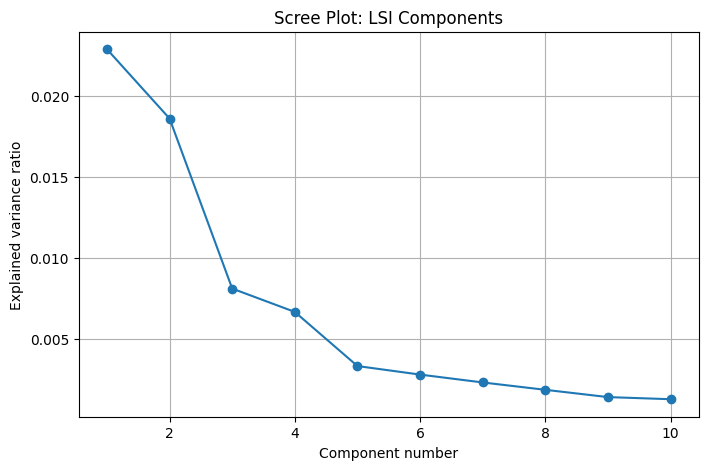

In [8]:
#Step 3: perform Dim. Rduction via LSI --> T

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=10, random_state=42) #many sc-atc - seq,  uusually utilizes  30-100 components.Random state for reproducability
#analyse data to learn  PC, and projecct the high dimd ata to lower dim space spanneds by these PC.
X_lsi = svd.fit_transform(adata.X)

#store as PCA embedding
adata.obsm["X_lsi"] = X_lsi

explained_var = svd.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.xlabel("Component number")
plt.ylabel("Explained variance ratio")
plt.title("Scree Plot: LSI Components")
plt.grid(True)
plt.show()



In [9]:
#Step4: neighbors and clustering
import scanpy

#Build nearest neighbors graphs oc cells using LSI components
scanpy.pp.neighbors(adata, use_rep="X_lsi", n_neighbors=17)
#Project cells into 2D space
scanpy.tl.umap(adata) 
#Perform Leiden clustering on the neighbor graph. --> ccluster cells into groups
scanpy.tl.leiden(adata, resolution=0.5) # clusters cell into subgroups

/opt/anaconda3/envs/VIB_model/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/qs/800v22r160x4jpwz94lztymw0000gn/T/ipykernel_3473/4283176168.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  scanpy.tl.leiden(adata, resolution=0.5) # clusters cell into subgroups


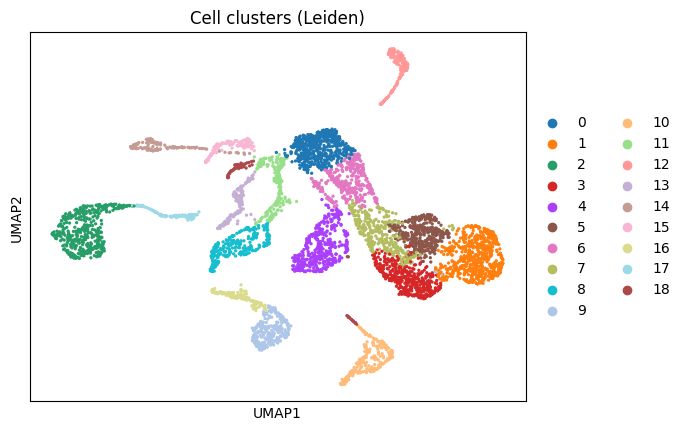

19


In [18]:
#Step 5: visualize clusters with UMAP
scanpy.pl.umap(adata, color = "leiden", title = "Cell clusters (Leiden)")


#get unique num of clusters
clusters = adata.obs["leiden"]
num_clusters = clusters.nunique()
print(num_clusters)

In [11]:
from pyfaidx import Fasta
#load genome  Fasta file
genome = Fasta("Genomes/Mus_musculus.GRCm39.dna.primary_assembly.fa")

#replace chr as str name because in genome there is only number
peaks['chr'] = peaks['chr'].str.replace('chr',"")
#function to get sequence
def get_sequence(row):
    return genome[row['chr']][row['start']:row['end']].seq

peaks['sequence'] = peaks.apply(get_sequence, axis=1) #aply the funcition getsequences


In [12]:
#Pad if seq < 150nt or trim it if is is larger
def pad_or_trim(seq, window_size = 150):
    seq = seq.upper()
    if len(seq) > window_size:
        return seq[:window_size]
    return seq + "N" * (window_size - len(seq)) #Pad with Ns


#Create one hot encoding function for the sequence
def one_hot_encoding(sequence):
    mapping = {"A":0, "C":1, "G":2, "T":3}
    one_hot = np.zeros((len(sequence), 4), dtype = np.int8) #rows-len of seq, and cols 4 possible nts
    for i, nt in enumerate(sequence.upper()):
        if nt in mapping:
            one_hot[i, mapping[nt]] = 1
    return one_hot


#add trimmed seq in the peaks 
peaks['trimmed_sequence'] = peaks['sequence'].apply(pad_or_trim)

#for all seqs
encoded_sequences = [one_hot_encoding(seq) for seq in peaks['trimmed_sequence']]



In [13]:
#PRepere the data for training
#not used: random sampling 

# import numpy as np
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.model_selection import train_test_split

# #Subsample peaks and cells, because 5K cells pairing with  197K peaks, leads to explosion s
# n_peaks = 5000
# n_cells = 1000

# selected_peaks = np.random.choice(peaks.index.values, n_peaks, replace = False)
# selected_cells_barcodes = np.random.choice(barcodes["cell_barcode"].values, n_cells, replace = False)
 
# #map cells barcods to integer positions
# barcode_to_idx = {barcode: i for i, barcode in enumerate(barcodes['cell_barcode'].values)}
# selected_cell_indices = [barcode_to_idx[bc] for bc in selected_cells_barcodes]

# #Step 2: subset the binary accessibility matrix
# matrix_sub = matrix_binary[selected_peaks, :][:, selected_cell_indices]

# #Prepeare sequence input
# X_seq_sub = np.stack([encoded_sequences[i] for i in selected_peaks]) #shape (n_peaks, 150, 4)
# X_seq_sub = np.repeat(X_seq_sub, repeats=n_cells, axis=0)  #shape (n_peaks*n_cells, 150, 4)

# #Prepate cell clucter input --> get lediden cluster of each selcted sell and on hot encode it
# cell_clusters_sub = adata.obs.loc[selected_cells_barcodes, 'leiden'].values.reshape(-1, 1)
# enc = OneHotEncoder(sparse_output=False)
# X_cell_onehot = enc.fit_transform(cell_clusters_sub)  # shape (n_cells, num_clusters)

# # Repeat cell cluster vectors for each peak
# X_cell_sub = np.tile(X_cell_onehot, (n_peaks, 1))  # shape (n_peaks*n_cells, num_clusters)
# #Prepeare labels --> this is accessibility values
# y_sub = matrix_sub.toarray().T.flatten()  # shape (n_peaks*n_cells,)

# X_seq_train, X_seq_test, X_cell_train, X_cell_test, y_train, y_test = train_test_split(
#     X_seq_sub, X_cell_sub, y_sub, test_size=0.2, random_state=42
# )

# print(X_seq_train.shape, X_cell_train.shape, y_train.shape)
# print(X_seq_test.shape, X_cell_test.shape, y_test.shape)


In [14]:
#Stratified sampling 
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#Subsample peaks and cells, because 5K cells pairing with  197K peaks, leads to explosion s
n_peaks = 5000
n_cells = 1000

#Get cluster labels for all cells, ligned with barcode order, use adata obejct
cell_clusters = adata.obs["leiden"].loc[barcodes["cell_barcode"].values].values
#Stratified sampling to select balance subse of cells based on cluster labels
sss = StratifiedShuffleSplit(n_splits= 1, test_size = n_cells, random_state= 42)
_, selected_cell_idx = next(sss.split(np.zeros(len(cell_clusters)), cell_clusters))
selected_cells_barcodes = barcodes["cell_barcode"].values[selected_cell_idx]

#Select most accessible peaks --> how many cells each peak is accessible--> pic the top 5K , NOTE we use original matrix
peak_sums = np.array(matrix_binary.sum(axis=1)).flatten()  # total accessibility per peak
top_peak_indices = peak_sums.argsort()[-n_peaks:]
selected_peaks = peaks.index.values[top_peak_indices]

#subset the binary matrix
matrix_sub = matrix_binary[selected_peaks, :][:, selected_cell_idx]

#Prepeare sequence input
X_seq_sub = np.stack([encoded_sequences[i] for i in selected_peaks]) #shape (n_peaks, 150, 4)
X_seq_sub = np.repeat(X_seq_sub, repeats=n_cells, axis=0)  #shape (n_peaks*n_cells, 150, 4)

#Prepate cell clucter input --> get lediden cluster of each selcted sell and on hot encode it
cell_clusters_sub = adata.obs.loc[selected_cells_barcodes, 'leiden'].values.reshape(-1, 1)
enc = OneHotEncoder(sparse_output=False)
X_cell_onehot = enc.fit_transform(cell_clusters_sub)  # shape (n_cells, num_clusters)

# Repeat cell cluster vectors for each peak
X_cell_sub = np.tile(X_cell_onehot, (n_peaks, 1))  # shape (n_peaks*n_cells, num_clusters)
#Prepeare labels --> this is accessibility values
y_sub = matrix_sub.toarray().T.flatten()  # shape (n_peaks*n_cells,) * 5 millions 

X_seq_train, X_seq_test, X_cell_train, X_cell_test, y_train, y_test = train_test_split(
    X_seq_sub, X_cell_sub, y_sub, test_size=0.2, random_state=42
)

In [15]:
from sklearn.utils import resample
#usapmling positive class
#sploit data into majority and minority class
X_seq_train_majority = X_seq_train[y_train == 0]
X_seq_train_minority = X_seq_train[y_train == 1]

#
X_cell_train_majority = X_cell_train[y_train == 0]
X_cell_train_minority = X_cell_train[y_train == 1]

y_train_majority = y_train[y_train == 0]
y_train_minority = y_train[y_train == 1]

# Upsample minority class
X_seq_minority_upsampled, X_cell_minority_upsampled, y_minority_upsampled = resample(
    X_seq_train_minority,
    X_cell_train_minority,
    y_train_minority,
    replace=True,
    n_samples=len(y_train_majority),
    random_state=42
)

# Combine majority and upsampled minority
X_seq_train_balanced = np.concatenate([X_seq_train_majority, X_seq_minority_upsampled])
X_cell_train_balanced = np.concatenate([X_cell_train_majority, X_cell_minority_upsampled])
y_train_balanced = np.concatenate([y_train_majority, y_minority_upsampled])



In [16]:
from collections import Counter
print(Counter(y_sub)) #65% zeros, and 35 non zeros.
print(Counter(y_train))
print(Counter(y_train_balanced))

Counter({0: 3237235, 1: 1762765})
Counter({0: 2589540, 1: 1410460})
Counter({0: 2589540, 1: 2589540})


In [19]:
#Use multi task with DNA sequence and cell type from cluster as input
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras import  metrics
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

seq_input = Input(shape=(150,4), name = "sequence_input")

#try to use blocks on DNA
#CNN block 1 on DNA
# x = Conv1D(filters = 32,kernel_size = 8, padding = "same", use_bias = False)(seq_input)
# x = BatchNormalization()(x)
# x = Activation("relu")(x)

# #CNN block 2 on DNA
# x = Conv1D(filters = 64, kernel_size =  4, padding = "same" , use_bias = False)(x)
# x = BatchNormalization()(x)
# x = Activation("relu")(x)


#try to use different kernel size to capture motifs with different length
#TF binding sites are usualy 5-20 bp long 
conv3 = Conv1D(64, 10, padding="same")(seq_input)
conv5 = Conv1D(64, 12, padding= "same")(seq_input)
conv8 = Conv1D(64, 15, padding= "same")(seq_input)

x = Concatenate()([conv3,conv5, conv8])

x = BatchNormalization()(x)
x = Activation("relu")(x)

x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)

#input cell type z
cell_type_input = Input(shape = (19,), name = "cell_type_input") # number of cell clusters from above



#Concatenate features
combined = Concatenate()([x,cell_type_input])
combined = Dense(64, use_bias = False)(combined)
combined = BatchNormalization()(combined)
combined = Activation("relu")(combined)
combined = Dropout(0.5)(combined)


output = Dense(1, activation = "sigmoid", name = "accessibility")(combined)

#build model
model = Model(inputs=[seq_input, cell_type_input], outputs = output)
#use adam optimizer with lower learing rate
optimizer = Adam(learning_rate = 1e-4) #default is 0.001 (1e-4)

metrics = [
    metrics.AUC(name="auc"),
    metrics.Precision(name = "precision"),
    metrics.Recall(name = "recall"),
    metrics.TruePositives(name="tp"),
    metrics.FalsePositives(name="fp")
]
model.compile(optimizer= optimizer, loss="binary_crossentropy", 
              metrics =metrics
             )
#we dont need class weights we did upsampling 
#Deal with imbalanced data, there are 5% of class 1, and 95% of samples are class 0. 
# class_weights = class_weight.compute_class_weight(
#         class_weight = "balanced",
#         classes = np.unique(y_train),
#         y = y_train)

#pass dict to the model- we dont need class weig
# class_weights_dict = dict(enumerate(class_weights))

#Include early stopping, because we have high overfitting (accuracy at 50% and val acucracy to 36%
early_stopping = EarlyStopping(monitor = "val_auc",
                               patience = 3,
                               mode = "max",
                               restore_best_weights = True)
                                

#fit model
model.fit(
    [X_seq_train_balanced, X_cell_train_balanced], y_train_balanced,
    validation_data=([X_seq_test, X_cell_test], y_test),
    epochs=10,#low epochs due to running time 
    batch_size=32,
    #class_weight = class_weights_dict, #model pays attention now to the rare class(in this case 1).
    callbacks = [early_stopping]
)

Epoch 1/10
161847/161847 ━━━━━━━━━━━━━━━━━━━━ 1021s 6ms/step - auc: 0.5287 - fp: 605904.5000 - loss: 0.7035 - precision: 0.5203 - recall: 0.5140 - tp: 677740.1875 - val_auc: 0.7424 - val_fp: 259739.0000 - val_loss: 0.6759 - val_precision: 0.5099 - val_recall: 0.7669 - val_tp: 270192.0000
Epoch 2/10
161847/161847 ━━━━━━━━━━━━━━━━━━━━ 987s 6ms/step - auc: 0.6281 - fp: 547801.0000 - loss: 0.6655 - precision: 0.5872 - recall: 0.6136 - tp: 814743.8750 - val_auc: 0.8132 - val_fp: 237661.0000 - val_loss: 0.5493 - val_precision: 0.5605 - val_recall: 0.8605 - val_tp: 303150.0000
Epoch 3/10
161847/161847 ━━━━━━━━━━━━━━━━━━━━ 1010s 6ms/step - auc: 0.7536 - fp: 496742.9375 - loss: 0.5853 - precision: 0.6685 - recall: 0.7735 - tp: 1004868.0000 - val_auc: 0.8234 - val_fp: 246349.0000 - val_loss: 0.5314 - val_precision: 0.5590 - val_recall: 0.8865 - val_tp: 312309.0000
Epoch 4/10
161847/161847 ━━━━━━━━━━━━━━━━━━━━ 1037s 6ms/step - auc: 0.7647 - fp: 494218.3750 - loss: 0.5735 - precision: 0.6748 - rec